# Constrainsts

In life you must set boundaries and in computational chemistry you can do the same thing. Let us investigate the consequences of changing the bong angle in water. We can easily obtain an optimized geometry but we want to force the bond angle into values outside of that perfect value. Its easy to role to the bottom of an energy well but how do we cling to its steep slope? We must set anchors. In this case we will set constrainsts.

## Optimize Bond Angle in Water

First we will optimize the geometry of water as we have done in the previous exercise. We will set up the structure using a Z-matrix as that is the easiest way to access a bond angle. The Z-matrix set that angle when we built the geomtry in the first place. So let us repeat the optimization from the previous notebook.

In [11]:
# use psi4conda environment
import psi4
import os
import numpy as np

output_file = "H2O_constrainst_1.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

# The Z-matrix as a text string
data = """
       0 1
       O1
       H2  1  length
       H3  1  length  2  angle
       length = 1.0
       angle = 110
       units angstrom
       """ 

# Create the Molecule object
mol = psi4.geometry(data)             # Create Molecule object from data string

psi4.set_options({
        "BASIS": "cc-pvdz",           # default => None - Basis set must be specified
        "SAVE_OPTIMIZATION": True,    # default => False
        "MAXITER": 100,               # default => 50
        "GEOM_MAXITER": 100,          # default => 50
        "FULL_HESS_EVERY": 5,         # default => -1
        "PRINT": 2,                   # default => 1
        "GUESS": "sad",               # default => auto
        "REFERENCE": "rhf",           # default => rhf
        "SCF_TYPE": "direct",         # default => pk
        "INTS_TOLERANCE": 1E-8        # default => 1e-12. A value of 1e-8 is recommended when SCF_TYPE set to "direct"
    })

start_angle = mol.get_variable("angle")
start_length = mol.get_variable("length")
print(f"Before optimization: {start_angle:.3f} degrees and {start_length:.3f} angstroms\n") 


opt_energy, hist = psi4.optimize("hf", molecule = mol, return_history=True)
print(f"The optimized energy for this configuration is {opt_energy:.7f} Hartree\n")

mol.print_out()
mol.print_distances()
mol.print_bond_angles()
mol.print_in_input_format()

opt_angle = mol.get_variable("angle")
opt_length = mol.get_variable("length")

print(f"After optimization: {opt_angle:.3f} degrees and {opt_length:.3f} angstroms\n") 


Before optimization: 110.000 degrees and 1.000 angstroms

Optimizer: Optimization complete!
The optimized energy for this configuration is -76.0270535 Hartree

After optimization: 104.617 degrees and 0.946 angstroms



## Changing a Variable

One way to investigate the effect of changing bond angle on energy would be to take this optimized structure and simply assign new bond angles and then calculate the energy. This is a simplistic approach becuase one knows that the bond length will change slightly with bond angle due to changes in hydridization (e.g., $sp^2$ bonds are shorter than $sp^3$ bonds.) However let us use this simple way to start.

### Scanning the Bond Angle

We have set up the geometry with a variable named "angle." That variable has been changed in the optimization but we can change it manually using the ```.set_variable()``` method of the Molecule object. We will set the angle to whatever we want, then update the geomtry (recalculate the *xyz* cartesian coordinates with the new angle). After that we will calculate the energy of the new geometry. Rinse and repeat through a series of values.

Recall how we did this with *Gamess*. We took the inoput file that we had constructed using the optimized geometry and then used the awesome text tools of *Unix* to change the angle (*grep*, *sed* and *awk* are the secret underpinning of modern science.) Then we subitted a whole batch of input files with different bond angles into *Gamess* on-at-a-time using the batch-queueing program *GamessQ*. But with the power of *Python* we cane do all this inside this notebook. We are using *Psi4* because it has an *Python* API that can be imported and used in a notebook like this.

In the code below we pick values from a range of values and asign them in turn to the variable "angle." in each case we caluclate the energy and append that value to a list. After the series of calculations is complete we will have a list of angles and a list of energies.



In [12]:
mol.set_variable("angle", 60)
energy = psi4.energy("hf", molecule = mol)
print((energy-opt_energy)*psi4.constants.hartree2kJmol)
start_angle = mol.get_variable("angle")
start_length = mol.get_variable("length")
print(f"Before optimization: {start_angle:.3f} degrees and {start_length:.3f} angstroms\n") 


177.73570312516017
Before optimization: 60.000 degrees and 0.946 angstroms



In [31]:
output_file = "H2O_constrainst_2.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

deviation = 10

start = opt_angle - deviation
end = opt_angle + deviation
number_of_points = 2 * deviation + 1
range_of_values = np.linspace(start, end, number_of_points) 

# We could also enter a set of values at which to to measure energies. try the range below and
# observe the energy profile. Can you explain it?
#range_of_values = [75,90,100,105,110,120,130,140,150,160,170,175,180,185,190,200,220,230,] 

angle_list = []
energy_list = []

for angle in range_of_values:
    mol.set_variable("angle", angle)
    energy = psi4.energy("hf", molecule = mol)
    angle_list.append(angle)
    energy_list.append(energy)

print(angle_list)
print(energy_list)

[94.61673136613041, 95.61673136613041, 96.61673136613041, 97.61673136613041, 98.61673136613041, 99.61673136613041, 100.61673136613041, 101.61673136613041, 102.61673136613041, 103.61673136613041, 104.61673136613041, 105.61673136613041, 106.61673136613041, 107.61673136613041, 108.61673136613041, 109.61673136613041, 110.61673136613041, 111.61673136613041, 112.61673136613041, 113.61673136613041, 114.61673136613041]
[-76.02414167848632, -76.02470712395643, -76.02520940052872, -76.02564930214108, -76.02602764379719, -76.02634526282861, -76.0266030199203, -76.02680179991108, -76.02694251239862, -76.0270260921427, -76.02705349930416, -76.02702571953355, -76.02694376393177, -76.02680866890515, -76.02662149593753, -76.02638333129993, -76.0260952857193, -76.0257584940253, -76.02537411479122, -76.02494332998512, -76.02446734464377]


## Data Handling

We just generated some data. List of numbers are kind of useless. We need to do some data manipulation.

A convenient tool for data handling is the *Pandas* library. It provides a powerful data object, the dataframe. We will combine the two lists into a dataframe. Then we will print the dataframe. We can output the dataframe as a csv file for future analysis. In many ways, we can manipulate a dataframe like a spreadsheet. Consider the code below.

In [32]:
import pandas as pd

data_dictionary = {"angle": angle_list,
                   "energy": energy_list}

df = pd.DataFrame.from_dict(data_dictionary)
#df.set_index('angle', inplace=True)
print(df.head())

       angle     energy
0  94.616731 -76.024142
1  95.616731 -76.024707
2  96.616731 -76.025209
3  97.616731 -76.025649
4  98.616731 -76.026028


### Math with a Dataframe

Lets do some math. We know the optimized energy from previous calulations above. We will subtract this lowets energy value from the energy column of the dataframe. Then we will multiply this column of relative energy values by a conversion factor to get kJ/mole rather than Hartrees.

In [33]:
df["energy"] = df["energy"] - opt_energy
df["energy"] = df["energy"] * psi4.constants.hartree2kJmol

### A Quick Plot

The dataframe object is very powerful. It contains a method that will plot the data. In the example below, we set which columns were to be used in the x and y-axis of the plot. Does this look like a typical energy profile for a vibration? the angle decreasing and increasing on either side of the optimal value is just like a bending vibration.

<Axes: xlabel='angle'>

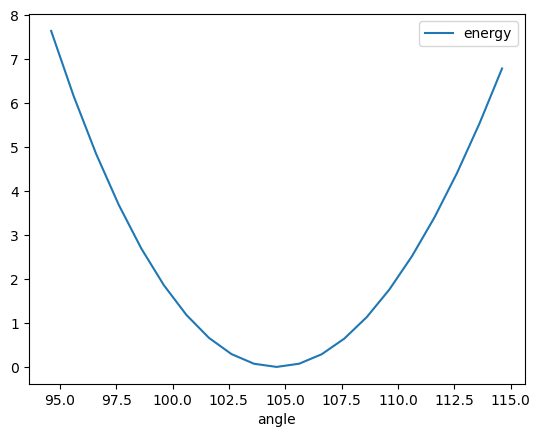

In [34]:
df.plot(x="angle", y = "energy", kind="line")   # try kind="scatter" as well